# Kaggle House Prices competition

## Libraries import

In [93]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

## Preprocessing data and model fit

In [94]:
available_models = {}

### Import and preprocess data

In [95]:
train_data = pd.read_csv("data/train.csv")
X = train_data.drop('SalePrice', axis=1)
y = train_data['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_transformer = SimpleImputer(strategy='constant')

categorical_transformer =Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

numerical_cols = [col for col in X_train.columns if X_train[col].dtype != 'object']
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']


datapreprocessor = ColumnTransformer(
    transformers=[
        ('num',numerical_transformer,numerical_cols),
        ('cat',categorical_transformer,categorical_cols)
    ])

### Model 1. Random Forest

Finding best parameters

In [96]:
# forest_model = RandomForestRegressor()
# forest_pipeline = Pipeline(steps=[('preprocessor', datapreprocessor),
#                               ('model', forest_model)])
# 
# forest_param_grid = {
#     'model__n_estimators': [50, 100, 500, 1000],  
#     'model__max_depth': [None, 3, 5, 10],     
#     'model__min_samples_split': [2, 5, 10],
#     'model__min_samples_leaf': [1, 2, 4] 
# }
# 
# random_search = RandomizedSearchCV(
#     estimator=forest_pipeline,
#     param_distributions=forest_param_grid,
#     n_iter=10,
#     scoring='neg_mean_squared_error',
#     cv=3,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )
# 
# grid_search.fit(X_train, y_train)
# 
# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

Fitting model with best parameters

In [97]:
model = RandomForestRegressor(n_estimators=1000, random_state=42, max_depth=3)

my_pipeline = Pipeline(steps=[('preprocessor', datapreprocessor),
                              ('model', model)
                              ])

my_pipeline.fit(X_train, y_train)

preds = my_pipeline.predict(X_valid)

mae = mean_absolute_error(preds, y_valid)
print(f"Mean Absolute Error: {mae}")

available_models["Random Forest"] = mae

Mean Absolute Error: 25846.23715907584


### Model 2. XGBoost

Finding best parameters

In [98]:
# xgb_model = XGBRegressor()
# xgb_pipeline = Pipeline(steps=[('preprocessor', datapreprocessor),
#                               ('model', xgb_model)])
# 
# xgb_param_grid = {
#     'model__n_estimators': [500, 1000],
#     'model__max_depth': [3, 5],
#     'model__learning_rate': [0.05, 0.1]
# }
# 
# random_search = RandomizedSearchCV(
#     estimator=xgb_pipeline,
#     param_distributions=xgb_param_grid,
#     n_iter=10, 
#     scoring='neg_mean_squared_error',
#     cv=3,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )
# 
# grid_search.fit(X_train, y_train)
# 
# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

Fitting model with best parameters

In [99]:
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4, max_depth=3)
xgb_pipeline = Pipeline(steps=[('preprocessor', datapreprocessor), ('model', xgb_model)])

xgb_pipeline.fit(X_train, y_train)

xgb_preds = xgb_pipeline.predict(X_valid)

xgb_mae = mean_absolute_error(xgb_preds, y_valid)
print(f"Mean Absolute Error: {xgb_mae}")

available_models["XGBoost"] = xgb_mae

Mean Absolute Error: 15978.14790239726


## Graphic. Which model has the best mae? Smaller - better

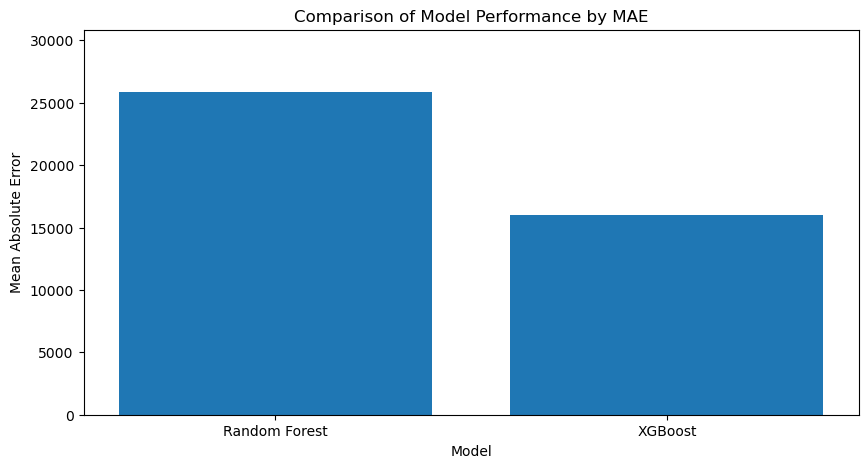

In [100]:
models = list(available_models.keys())
mae_values = list(available_models.values())


plt.figure(figsize=(10, 5)) 
plt.bar(models, mae_values) 

plt.title('Comparison of Model Performance by MAE')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error')
plt.ylim(0, max(mae_values) + 5000)  

plt.show()

## Final model and submission.csv generation

In [101]:
test_data = pd.read_csv("data/test.csv")

final_preds = xgb_pipeline.predict(test_data)

output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': final_preds})
output.to_csv('submission.csv', index=False)